# Importing Libraries

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import json
from tools import *

# Loading original Dataset

In [143]:
# Load the CSV file into a pandas DataFrame
original_dataset = pd.read_csv("datasets/original_dataset.txt", delimiter='\t', low_memory=False)


# Cleaning Dataset

In [144]:

clean_dataset = original_dataset

# Replace '.' with 0 in the entire DataFrame
clean_dataset.replace('.', 0, inplace=True)

# For Column FGRStrand
clean_dataset.replace('+', 1, inplace=True)
clean_dataset.replace('-', -1, inplace=True)

# Remove the prefix from column 'peakName'
clean_dataset['peakName'] = clean_dataset['peakName'].str.replace('chm13v2_accessible_region_', '', regex=False)

# Replace the strings in the 'region' column with their corresponding indices
clean_dataset['region'] = clean_dataset['region'].map(region_dict)

# Dropping 'FGR' 'cause it seems that it has weird data
clean_dataset = clean_dataset.drop(columns=['FGR'])

# Dropping 'FGR' 'cause it seems that it has weird data
clean_dataset = clean_dataset.drop(columns=['chr'])

# Remove rows where FGRstart<0
clean_dataset = clean_dataset[clean_dataset['FGRstart'] >= 0]



In [145]:
clean_dataset['region']

0         0
1         0
2         0
3         0
4         0
         ..
107176    6
107616    6
108363    6
110502    6
110805    6
Name: region, Length: 85413, dtype: int64

In [146]:

#These are the columns NOT linked to a protein
non_k562_columns = [col for col in clean_dataset.columns if 'K562' not in col]
nb_ATAC_seq_rows = len(non_k562_columns)

ATAC_seq_column_name_list = ""
for col in non_k562_columns:
    ATAC_seq_column_name_list += f'{col} '  
print(ATAC_seq_column_name_list)
    
# Specify the index for the first column to convert (e.g., nb_ATAC_seq_rows)
# Ensure that nb_ATAC_seq_rows is defined before this code

# Select columns from nb_ATAC_seq_rows to the last one
columns_to_convert = clean_dataset.iloc[:, nb_ATAC_seq_rows:]

# Convert the selected columns to numeric, forcing errors to NaN
transformed_columns = columns_to_convert.apply(pd.to_numeric, errors='coerce')

# Select the non-transformed columns (from the start to nb_ATAC_seq_rows)
non_transformed_columns = clean_dataset.iloc[:, :nb_ATAC_seq_rows]

# Concatenate the non-transformed columns with the transformed columns
clean_numeric_dataset = pd.concat([non_transformed_columns, transformed_columns], axis=1)




peakStart peakEnd peakName peakScore FGRstart FGRend FGRstrand region 


In [147]:
clean_numeric_dataset.shape

(85413, 458)

# Extracting Protein Names from Column Titles

In [148]:

# Extract column names from the 11th column to the last
protein_run_set = clean_numeric_dataset.columns[nb_ATAC_seq_rows:]

# Extract the protein names (second part of the string) using a list comprehension
proteins = list([col.split('_')[1] for col in protein_run_set])


# # Count occurrences of each unique protein
protein_count = Counter(proteins)


# Listing sets of proteins that occur 2, 3 or more times

In [149]:

def plot_protein_histogram(proteins, bar_width=0.4):
    # Count occurrences of each unique protein
    protein_count = Counter(proteins)

    # Create a dictionary of proteins that occur more than once
    dict_list = []
    for i in [1, 2, 3]:
        dict_list.append({protein: count for protein, count in protein_count.items() if count > i})
        filename = f"proteins_occ_more_than_{i}.png"

        # Set up the figure with the specified size
        num_proteins = len(dict_list[i-1])
        plt.figure(figsize=(8, num_proteins * bar_width * 0.6))  # Adjust the height based on number of proteins

        # Create the histogram (note the order of x and y)
        plt.barh(list(dict_list[i-1].keys()), list(dict_list[i-1].values()), color='skyblue', height=bar_width)

        # Add labels and title
        plt.ylabel('Proteins')
        plt.xlabel('Number of Occurrences')
        plt.title(f'Histogram of Proteins Occurring More Than {i} times')
        plt.ylim(-0.5, num_proteins - 0.5)  # Adjust the limits to remove extra space

        # Save the plot as a PNG file
        plt.tight_layout()  # Adjust layout to fit labels
        plt.savefig(f'images/other/{filename}')  # Save the figure
        # plt.show()
        plt.close()  # Close the plot to free up memory

        print(f'There are {len(dict_list[i-1])} unique proteins that occur more than {i} times')
        print(dict_list[i-1])



plot_protein_histogram(proteins)

There are 89 unique proteins that occur more than 1 times
{'AFF1': 2, 'ARNT': 3, 'ATF3': 3, 'BCLAF1': 2, 'CBX3': 2, 'CEBPB': 2, 'CHAMP1': 2, 'CSDE1': 2, 'CTCF': 5, 'DPF2': 2, 'E2F1': 2, 'E2F6': 2, 'EGR1': 3, 'ELF1': 2, 'EP300': 2, 'ETV6': 2, 'FOXK2': 2, 'GATA1': 2, 'GATA2': 2, 'GTF2F1': 3, 'H3K27me3': 3, 'H3K36me3': 2, 'H3K4me1': 2, 'H3K4me3': 4, 'H3K9ac': 2, 'HDAC1': 4, 'HDAC2': 4, 'HDGF': 2, 'IKZF1': 2, 'JUN': 2, 'KDM1A': 3, 'KDM4B': 2, 'LEF1': 2, 'MAX': 3, 'MCM2': 2, 'MCM5': 2, 'MCM7': 3, 'MITF': 2, 'MLLT1': 2, 'MNT': 3, 'MTA2': 2, 'MYC': 3, 'NCOA1': 3, 'NCOA2': 2, 'NCOR1': 4, 'NFATC3': 2, 'NFE2': 2, 'NFRKB': 2, 'NONO': 2, 'NR3C1': 2, 'NRF1': 4, 'POLR2A': 6, 'POLR2AphosphoS2': 2, 'RAD21': 2, 'RCOR1': 2, 'REST': 3, 'RFX1': 2, 'RNF2': 5, 'RUNX1': 2, 'SETDB1': 2, 'SIN3A': 2, 'SIRT6': 2, 'SIX5': 2, 'SMARCA4': 3, 'SP1': 2, 'SUZ12': 2, 'TAL1': 2, 'TARDBP': 3, 'TBL1XR1': 2, 'TCF12': 2, 'TRIM24': 2, 'TRIM25': 2, 'TRIM28': 3, 'UBTF': 2, 'YY1': 3, 'ZBTB33': 2, 'ZBTB5': 2, 'ZC3H8': 2, 'ZEB2': 

# Dropping Proteins that only occur once

In [150]:
# Listing proteins that occur only once (less than 2 times)
less_than_2 = {protein: count for protein, count in protein_count.items() if count < 2}
print(len(less_than_2))

# Creating a copy of the dataset that only keeps proteins that occur more than once
dataset_more_than_1 = clean_numeric_dataset
print(f'Original #Columns: {dataset_more_than_1.shape[1]}')

for protein in less_than_2:
    columns_to_drop = dataset_more_than_1.filter(like=f'{protein}').columns
    dataset_more_than_1.drop(columns=columns_to_drop, inplace=True)

print(f'Final #Columns: {dataset_more_than_1.shape[1]}')

235
Original #Columns: 458
Final #Columns: 223


# Filtering Dataset: keeping rows where 'peakScore' is within one STDEV

In [151]:
highest_peak_score = dataset_more_than_1['peakScore'].max()
print(f'Highest peakScore: {highest_peak_score}')

lowest_peak_score = dataset_more_than_1['peakScore'].min()
print(f'Lowest peakScore: {lowest_peak_score}')

mean_peak_score = dataset_more_than_1['peakScore'].mean()
print(f'Mean peakScore: {mean_peak_score}')

stdv_peak_score = dataset_more_than_1['peakScore'].std()
print(f'Stdev peakScore: {stdv_peak_score}')


# Define the bounds for peakScore within 3 standard deviations
threshold = 1
lower_bound = 0
upper_bound = mean_peak_score + threshold * stdv_peak_score

# Filter the dataset to keep only the rows within these bounds
filtered_dataset = dataset_more_than_1[(dataset_more_than_1['peakScore'] >= lower_bound) & (dataset_more_than_1['peakScore'] <= upper_bound)]

print(f'Dataset reduced from {dataset_more_than_1.shape[0]} to {filtered_dataset.shape[0]} rows')
print(f'That reduction means that ~{int(100*filtered_dataset.shape[0]/dataset_more_than_1.shape[0])}% of the data has been kept')

# Plot the histogram of the 'peakScore' column
plt.figure(figsize=(10, 6))
plt.hist(filtered_dataset['peakScore'], bins=100, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Peak Score', fontsize=16)
plt.xlabel('Peak Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.grid(axis='y', alpha=0.75)
plt.savefig('images/other/PeakScoreDistribution.png')  # Save the figure
plt.close()

Highest peakScore: 104617
Lowest peakScore: 13
Mean peakScore: 198.0256167094002
Stdev peakScore: 540.4664950452996
Dataset reduced from 85413 to 81357 rows
That reduction means that ~95% of the data has been kept


 # Storing filtered dataset

In [152]:
original_cell_count = original_dataset.shape[0]*original_dataset.shape[1]
clean_cell_count = clean_numeric_dataset.shape[0]*clean_numeric_dataset.shape[1]

print(f'Clean dataset has only {int(100*clean_cell_count/original_cell_count)}% of original cells')

original_cell_count = original_dataset.shape[0]*original_dataset.shape[1]
filtered_cell_count = filtered_dataset.shape[0]*filtered_dataset.shape[1]

print(f'Filtered dataset has only {int(100*filtered_cell_count/original_cell_count)}% of original cells')
filtered_dataset.to_csv("datasets/filtered_dataset.csv", index=False)

Clean dataset has only 36% of original cells
Filtered dataset has only 34% of original cells


# Merging Columns of 'repeated' Proteins

In [153]:
# 1. Extract the protein name from the column headers
protein_groups = filtered_dataset.columns.str.split('_').str[1]  # Extract protein names (2nd part of the name)

# 2. Group columns by the extracted protein name
merged_columns = filtered_dataset.groupby(protein_groups, axis=1).mean().astype(int)

merged_dataset = pd.concat([filtered_dataset.iloc[:, :nb_ATAC_seq_rows] , merged_columns], axis=1)
merged_dataset.to_csv("datasets/merged_dataset.csv", index=False)

/tmp/ipykernel_235768/2105206082.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  merged_columns = filtered_dataset.groupby(protein_groups, axis=1).mean().astype(int)


# Drawing Pie Chart with Distribution of Genomic Regions

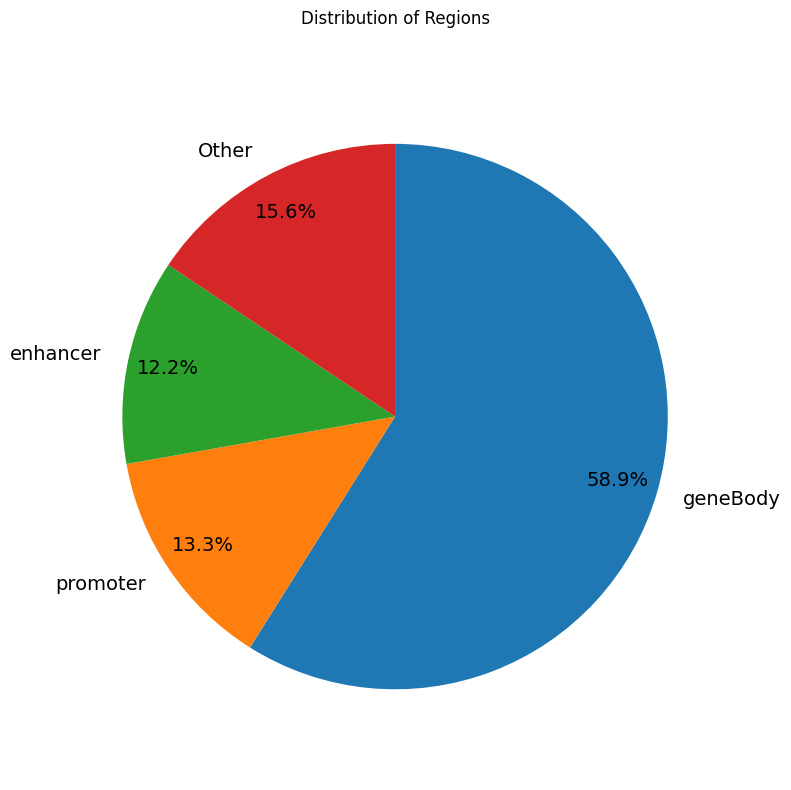

In [155]:


# Group N regions with the least occurrences into 'Other'
num_to_group = 4  # Number of smallest regions to group

# Invert the dictionary
region_mapping = {value: key for key, value in region_dict.items()}

# Replace the numeric values in the 'region' column with their corresponding string labels
merged_dataset['region'] = merged_dataset['region'].replace(region_mapping)

# Count occurrences of each unique value in the 'region' column
region_counts = merged_dataset['region'].value_counts()

# Least common regions
least_common_regions = region_counts.nsmallest(num_to_group)

# Create a new Series with the grouped 'Other' category
region_counts_grouped = region_counts.drop(least_common_regions.index)
region_counts_grouped['Other'] = least_common_regions.sum()

# Plot the pie chart with the grouped data
plt.figure(figsize=(8, 8))

# Adjust pie size and label font size
plt.pie(
    region_counts_grouped, 
    labels=region_counts_grouped.index,  # Use the string labels
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False, 
    textprops={'fontsize': 14},  # Increase label font size
    pctdistance=0.85  # Make pie smaller (increase space between slices and percentage labels)
)

plt.title('Distribution of Regions\n')

# Ensure there's enough margin so labels don't get cropped
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.tight_layout()  # Adjust layout to ensure no elements are cropped

plt.savefig('images/other/piechart_regions.png')